In [2]:
import os
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
from utils.exp_utils import list_concept_names, list_exp_names

In [18]:
class ExpScoreKeeper:
    def __init__(self, base_path, dataset_name, exp_name, model_name):
        self.base_path = base_path
        self.dataset_name = dataset_name
        self.exp_name = exp_name
        self.model_name = model_name
        with open(f"{base_path}/{dataset_name}/{exp_name}_{model_name}.pkl", "rb") as f:
            self.data = pk.load(f)
        self.concept = list(self.data.keys())
        for concept in self.concept:
            # self.data[concept]['distinction_score'] *= 2
            self.data[concept]['final_score'] = (
                self.data[concept]['consistency_score'] 
                - self.data[concept]['distinction_score']
                + self.data[concept]['relevance_score']
            )

        self.consistency = np.mean([self.data[concept]["consistency_score"] for concept in self.concept])
        self.distinction = np.mean([self.data[concept]["distinction_score"] for concept in self.concept])
        self.relevance = np.mean([self.data[concept]["relevance_score"] for concept in self.concept])

        self.consistency_std = np.std([self.data[concept]["consistency_score"] for concept in self.concept])
        self.distinction_std = np.std([self.data[concept]["distinction_score"] for concept in self.concept])
        self.relevance_std = np.std([self.data[concept]["relevance_score"] for concept in self.concept])

        self.final_score = self.consistency - self.distinction + self.relevance
        self.final_score_std = np.sqrt(self.consistency_std**2 + self.distinction_std**2 + self.relevance_std**2)

    def __str__(self):
        return f"""
Concept: {self.concept}
Concept Length: {len(self.concept)}
Base Path: {self.base_path}
Dataset Name: {self.dataset_name}
Experiment Name: {self.exp_name}
Model Name: {self.model_name}
Final Score: {self.final_score}
Final Score Std: {self.final_score_std}
"""
    
    def show_details(self):
        print(
f"""
Detail Scores:
Consistency: {self.consistency}
Distinction: {self.distinction}
relevance: {self.relevance}

Consistency Std: {self.consistency_std}
Distinction Std: {self.distinction_std}
relevance Std: {self.relevance_std}
"""
        )

    def get_concept_score(self, concept):
        if concept not in self.concept:
            raise ValueError(f"Concept {concept} not found in the experiment data.")
        print(f"Scores for concept {concept}:")
        print(f"Consistency: {self.data[concept]['consistency_score']}")
        print(f"Distinction: {self.data[concept]['distinction_score']}")
        print(f"Relevance: {self.data[concept]['relevance_score']}")
        print(f"Final Score: {self.data[concept]['final_score']}")


In [19]:
base_path = "/home/jack/Code/Research/instree_analysis/experiment_image/scores"
dataset_name = "v2_sub_clip"

exp_names = list_exp_names(dataset_name)
# cpt_names = list_concept_names(dataset_name)

===== Experiment names for v2_sub_clip: =====
0 20250425_instree_fixed
1 20250426_0410
2 20250427_0426_0.95
3 20250428_0426_1
4 20250429_0426_seed0
5 20250506_abla_rand_1
6 20250507_abla_no_attn
7 20250508_0429_rand_0.6
8 20250508_0429_rand_0.7
9 20250508_0429_rand_0.8
===== Total experiments: 10 =====


In [20]:
exp_idx = [7, 8, 9, 4, 5, 0]
analysis_name = [exp_names[i] for i in exp_idx]
sk_clip = []
sk_dino = []
for exp_name in analysis_name:
    print(f"Loading {dataset_name} {exp_name}")
    for model_name in ["clip", "dino"]:
        sk = ExpScoreKeeper(base_path, dataset_name, exp_name, model_name)
        if model_name == "clip":
            sk_clip.append(sk)
        else:
            sk_dino.append(sk)

Loading v2_sub_clip 20250508_0429_rand_0.6
Loading v2_sub_clip 20250508_0429_rand_0.7
Loading v2_sub_clip 20250508_0429_rand_0.8
Loading v2_sub_clip 20250429_0426_seed0
Loading v2_sub_clip 20250506_abla_rand_1
Loading v2_sub_clip 20250425_instree_fixed


In [21]:
sk_clip[1].get_concept_score('canada_bear')

Scores for concept canada_bear:
Consistency: 1.633317470550537
Distinction: 0.656909167766571
Relevance: 1.512773036956787
Final Score: 2.4891812801361084


In [22]:
for skc, skd, name in zip(sk_clip, sk_dino, analysis_name):
    print(f"===== Exp: {name} =====")
    print("~~~ CLIP-based Evaluation ~~~")
    print(skc)
    skd.show_details()
    print("~~~ DINO-based Evaluation ~~~")
    print(skd)
    skd.show_details()

===== Exp: 20250508_0429_rand_0.6 =====
~~~ CLIP-based Evaluation ~~~

Concept: ['green_dall', 'mug_buildings', 'buddha', 'canada_bear', 'decoritems_woodenpot', 'mug_skulls', 'plushie_tortoise', 'cat_statue', 'red_teapot', 'round_bird', 'colorful_teapot', 'elephant', 'physics_mug']
Concept Length: 13
Base Path: /home/jack/Code/Research/instree_analysis/experiment_image/scores
Dataset Name: v2_sub_clip
Experiment Name: 20250508_0429_rand_0.6
Model Name: clip
Final Score: 2.318542003631592
Final Score Std: 0.18519625316795846


Detail Scores:
Consistency: 1.5584485530853271
Distinction: 0.7400608062744141
relevance: 1.1891382932662964

Consistency Std: 0.05699465051293373
Distinction Std: 0.032153788954019547
relevance Std: 0.11467059701681137

~~~ DINO-based Evaluation ~~~

Concept: ['green_dall', 'mug_buildings', 'buddha', 'canada_bear', 'decoritems_woodenpot', 'mug_skulls', 'plushie_tortoise', 'cat_statue', 'red_teapot', 'round_bird', 'colorful_teapot', 'elephant', 'physics_mug']
Conc

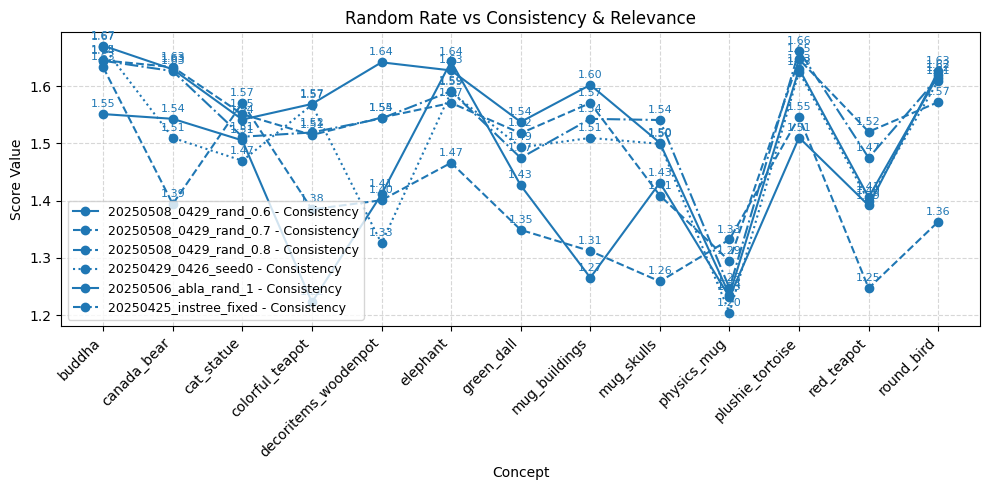

In [23]:
def plot_concept_multi_field_line_comparison_with_labels(dict_list, fields=['consistency', 'distinction', 'relevance'], title='Multi-Score Line Comparison'):
    label_list = [d.exp_name for d in dict_list]
    
    # 找出共通的 concept
    concept_sets = [set(d.concept) for d in dict_list]
    common_concepts = sorted(set.intersection(*concept_sets))
    
    if not common_concepts:
        print("No common concepts to compare.")
        return

    x = np.arange(len(common_concepts))
    fig, ax = plt.subplots(figsize=(10, 5))

    # 顏色與線型設計
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    linestyles = ['-', '--', '-.', ':']

    for i, d in enumerate(dict_list):
        for j, field in enumerate(fields):
            scores = [d.data[c][f"{field}_score"] for c in common_concepts]
            label = f"{label_list[i]} - {field.capitalize()}"
            color = colors[j % len(colors)]
            linestyle = linestyles[i % len(linestyles)]

            # 繪圖
            ax.plot(x, scores, label=label, linestyle=linestyle, marker='o', color=color)

            # 標上數值
            for xi, yi in zip(x, scores):
                ax.annotate(f'{yi:.2f}', xy=(xi, yi), xytext=(0, 5),
                            textcoords="offset points", ha='center', fontsize=8, color=color)

    ax.set_xlabel('Concept')
    ax.set_ylabel('Score Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(common_concepts, rotation=45, ha='right')
    ax.legend(loc='best', fontsize=9)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_concept_multi_field_line_comparison_with_labels(sk_clip, fields=['consistency'], title='Random Rate vs Consistency & Relevance')

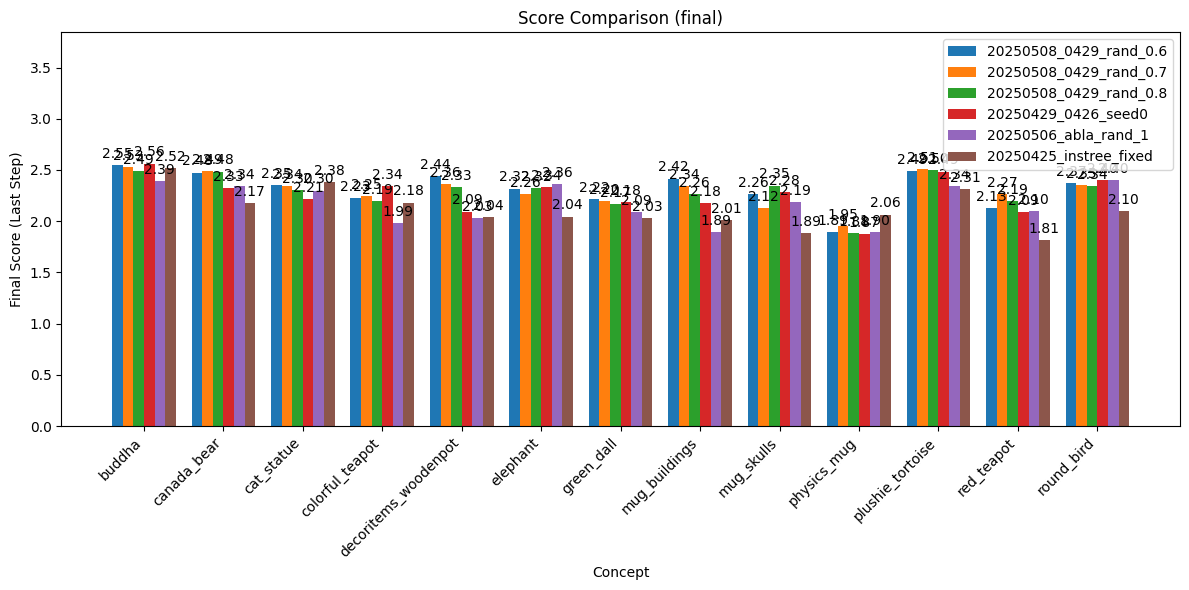

In [24]:
def plot_concept_comparison(dict_list, field='consistency', title='Score Comparison'):
    title += " ({})".format(field)
    label_list = [dict.exp_name for dict in dict_list]
    
    # Get common concepts across all dictionaries
    concept_sets = [set(d.concept) for d in dict_list]
    common_concepts = sorted(set.intersection(*concept_sets))
    
    if not common_concepts:
        print("No common concepts to compare.")
        return

    n_dicts = len(dict_list)
    x = np.arange(len(common_concepts))
    width = 0.8 / n_dicts  # Adjust total bar width

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (d, label) in enumerate(zip(dict_list, label_list)):
        scores = [d.data[c][field+"_score"] for c in common_concepts]
        bars = ax.bar(x + i * width - (n_dicts - 1) * width / 2, scores, width, label=label)
        
        # Add value labels on top of each bar
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    ax.set_xlabel('Concept')
    ax.set_ylabel('Final Score (Last Step)')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(common_concepts, rotation=45, ha='right')
    ylim = max(max([d.data[c][field+"_score"] for c in common_concepts]) for d in dict_list)  * 1.5
    ax.set_ylim(0, ylim)
    ax.legend(loc='best')
    plt.tight_layout()
    plt.show()

plot_concept_comparison(sk_clip, field='final')


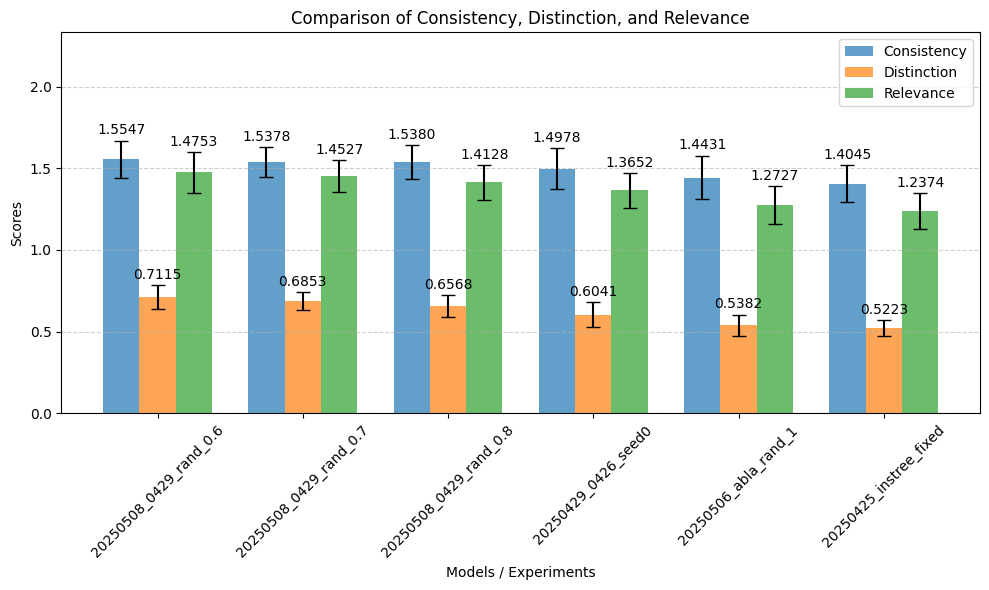

In [25]:
def plot_all_scores_one_plot(score_keepers):
    # Extracting model names and experiment names
    model_names = [sk.model_name for sk in score_keepers]
    exp_names = [sk.exp_name for sk in score_keepers]

    # Metrics data
    metrics = ["consistency", "distinction", "relevance"]
    means = {
        "consistency": [sk.consistency for sk in score_keepers],
        "distinction": [sk.distinction for sk in score_keepers],
        "relevance": [sk.relevance for sk in score_keepers]
    }
    stds = {
        "consistency": [sk.consistency_std for sk in score_keepers],
        "distinction": [sk.distinction_std for sk in score_keepers],
        "relevance": [sk.relevance_std for sk in score_keepers]
    }

    x = np.arange(len(score_keepers))  # x locations for the bars
    width = 0.25  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plots for each metric
    ax.bar(x - width, means["consistency"], width, yerr=stds["consistency"], capsize=5, label='Consistency', alpha=0.7)
    ax.bar(x, means["distinction"], width, yerr=stds["distinction"], capsize=5, label='Distinction', alpha=0.7)
    ax.bar(x + width, means["relevance"], width, yerr=stds["relevance"], capsize=5, label='Relevance', alpha=0.7)

    # Add numerical values on top of the bars
    for i in range(len(score_keepers)):
        ax.text(x[i] - width, means["consistency"][i] + stds["consistency"][i] + 0.02,  # Position above the bar
                f'{means["consistency"][i]:.4f}', ha='center', va='bottom', color='black')
        ax.text(x[i], means["distinction"][i] + stds["distinction"][i] + 0.02,  # Position above the bar
                f'{means["distinction"][i]:.4f}', ha='center', va='bottom', color='black')
        ax.text(x[i] + width, means["relevance"][i] + stds["relevance"][i] + 0.02,  # Position above the bar
                f'{means["relevance"][i]:.4f}', ha='center', va='bottom', color='black')

    # Labels and Titles
    ax.set_xlabel('Models / Experiments')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Consistency, Distinction, and Relevance')
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names, rotation=45)
    ax.set_ylim(0, max(max(means["consistency"]), max(means["distinction"]), max(means["relevance"])) * 1.5)
    ax.legend()

    # Grid and Layout
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

plot_all_scores_one_plot(sk_clip) 

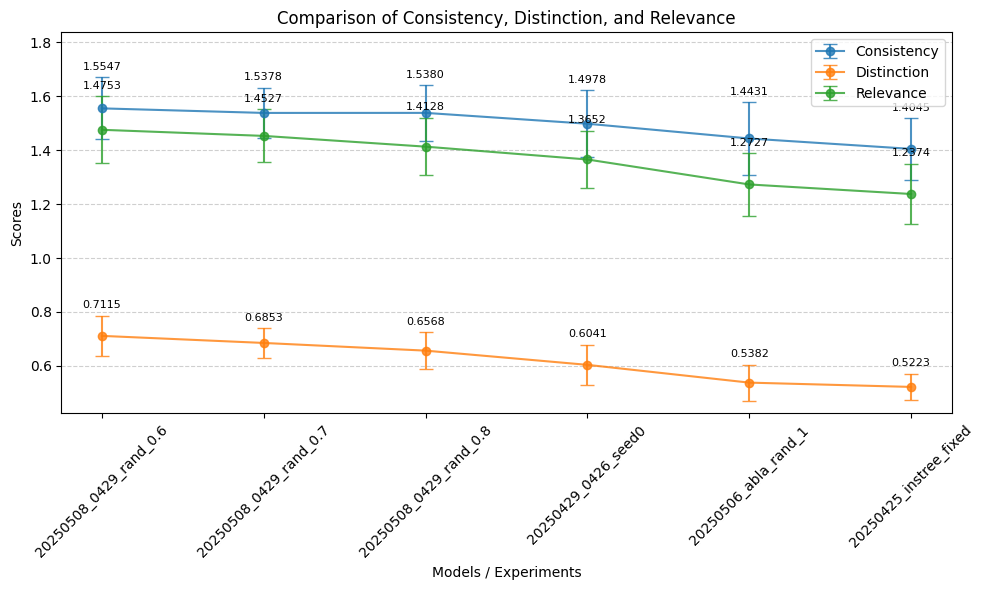

In [26]:
def plot_all_scores_one_plot(score_keepers, fields = ["consistency", "distinction", "relevance"]):
    # Extracting experiment names (x-axis labels)
    exp_names = [sk.exp_name for sk in score_keepers]

    means = {
        "consistency": [sk.consistency for sk in score_keepers],
        "distinction": [sk.distinction for sk in score_keepers],
        "relevance": [sk.relevance for sk in score_keepers]
    }
    stds = {
        "consistency": [sk.consistency_std for sk in score_keepers],
        "distinction": [sk.distinction_std for sk in score_keepers],
        "relevance": [sk.relevance_std for sk in score_keepers]
    }

    x = np.arange(len(score_keepers))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Line plots for each metric with error bars
    for metric in fields:
        ax.errorbar(
            x,
            means[metric],
            yerr=stds[metric],
            fmt='-o',
            capsize=5,
            label=metric.capitalize(),
            alpha=0.8
        )

        # Add numerical values on each point
        for i in range(len(score_keepers)):
            ax.text(x[i], means[metric][i] + stds[metric][i] + 0.02,
                    f'{means[metric][i]:.4f}', ha='center', va='bottom', fontsize=8)

    # Labels and Title
    ax.set_xlabel('Models / Experiments')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Consistency, Distinction, and Relevance')
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names, rotation=45)
    ax.set_ylim(min(min(means[m][i] - stds[m][i] for i in range(len(x))) for m in fields) * 0.9,
                max(max(means[m][i] + stds[m][i] for i in range(len(x))) for m in fields) * 1.1)
    ax.legend()

    # Grid and Layout
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example usage
plot_all_scores_one_plot(sk_clip, fields = ["consistency", "distinction", "relevance"])

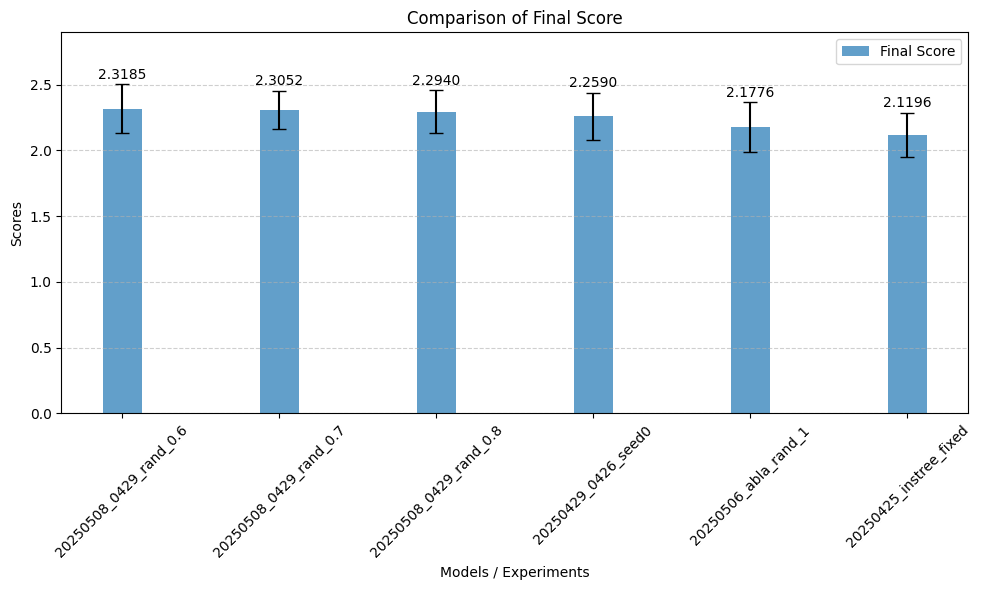

In [27]:
def plot_all_scores_one_plot(score_keepers):
    # Extracting model names and experiment names
    model_names = [sk.model_name for sk in score_keepers]
    exp_names = [sk.exp_name for sk in score_keepers]

    # Metrics data
    metrics = ["final_score"]
    means = {
        "final_score": [sk.final_score for sk in score_keepers],
    }
    stds = {
        "final_score": [sk.final_score_std for sk in score_keepers],
    }

    x = np.arange(len(score_keepers))  # x locations for the bars
    width = 0.25  # Width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plots for each metric
    ax.bar(x, means["final_score"], width, yerr=stds["final_score"], capsize=5, label='Final Score', alpha=0.7)

    # Add numerical values on top of the bars
    for i in range(len(score_keepers)):
        ax.text(x[i], means["final_score"][i] + stds["final_score"][i] + 0.02,  # Position above the bar
                f'{means["final_score"][i]:.4f}', ha='center', va='bottom', color='black')

    # Labels and Titles
    ax.set_xlabel('Models / Experiments')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Final Score')
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names, rotation=45)
    ax.set_ylim(0, max(means["final_score"]) * 1.25)
    ax.legend()

    # Grid and Layout
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

plot_all_scores_one_plot(sk_clip)

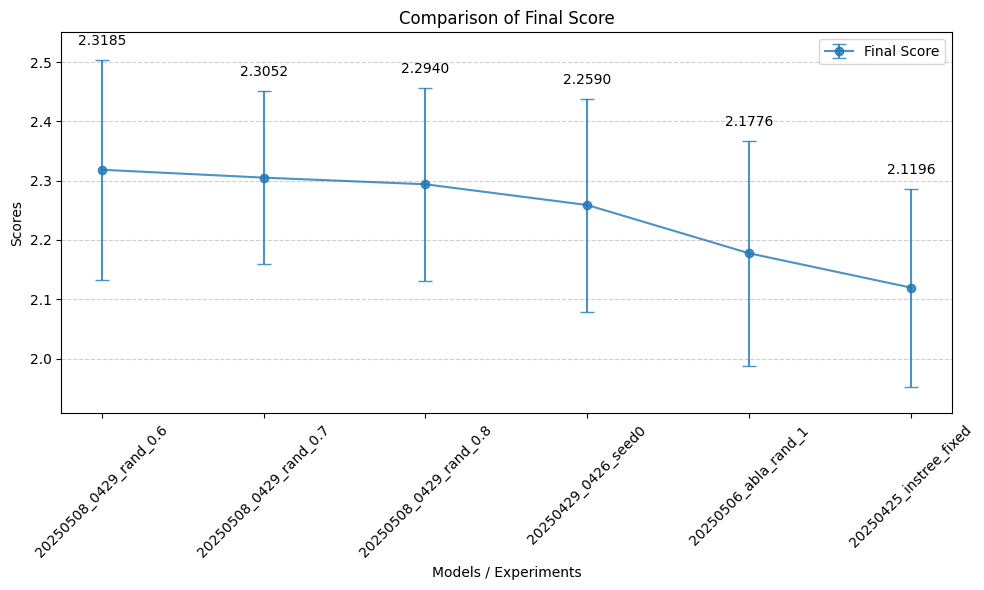

In [30]:
def plot_all_scores_one_plot(score_keepers):
    # Extracting experiment names (x-axis labels) and metric data
    exp_names = [sk.exp_name for sk in score_keepers]
    means = [sk.final_score for sk in score_keepers]
    stds = [sk.final_score_std for sk in score_keepers]

    x = np.arange(len(score_keepers))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting the line with error bars
    ax.errorbar(x, means, yerr=stds, fmt='-o', capsize=5, label='Final Score', alpha=0.8)

    # Add numerical values on top of each point
    for i in range(len(score_keepers)):
        ax.text(x[i], means[i] + stds[i] + 0.02, f'{means[i]:.4f}', ha='center', va='bottom', color='black')

    # Labels and Titles
    ax.set_xlabel('Models / Experiments')
    ax.set_ylabel('Scores')
    ax.set_title('Comparison of Final Score')
    ax.set_xticks(x)
    ax.set_xticklabels(exp_names, rotation=45)
    ax.set_ylim(min(means) * 0.9, max(means) * 1.1)
    ax.legend()

    # Grid and Layout
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()

    plt.show()

# 呼叫範例
plot_all_scores_one_plot(sk_clip)
